In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from pathlib import Path

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange, reduce, repeat
from jaxtyping import Float, Int, Bool
from torch.utils.data import DataLoader

import wandb

# Numeric
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [4]:
from reprpo.interventions.config import ExperimentConfig
from reprpo.models.load import load_model, print_trainable_parameters
args = ExperimentConfig(batch_size=2)
args

ExperimentConfig(dataset='us_history_textbook', verbose=1, dev=False, load_in_4bit=False, load_in_8bit=False, use_gradient_checkpointing=False, batch_size=2, n_samples=5400, eval_samples=None, max_length=196, max_prompt_length=96, base_model='wassname/llama-3-2-1b-sft', save=True, wandb=True)

## Load model

In [5]:
model, tokenizer = load_model(args.base_model, load_in_4bit=args.load_in_4bit,  load_in_8bit=args.load_in_8bit,  
                            #   attn_implementation='eager' # for gemma
)
model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm

In [6]:
# peft_config = LoraConfig(
#     r=64,
#     lora_alpha=16,
#     use_rslora=True,
#     # use_dora=True,
#     task_type="CAUSAL_LM",
#     # target_modules=["all-linear"], #  QLoRA-style training
# )
# # if hasattr(PL_MODEL, 'setup_grad_proj'):
# #     peft_config = PL_MODEL.setup_grad_proj(peft_config)

# model = get_peft_model(model, peft_config, adapter_name=adapter_name)
# print_trainable_parameters(model)

## Dataset

In [7]:
from datasets import load_dataset
from reprpo.data.collate3 import TokenizeRow

def ds2dl(ds):
    return DataLoader(
        ds
        .select_columns(["chosen", "rejected", "chosen_mask", "rejected_mask"])
        .with_format("torch"),
        batch_size=args.batch_size,
    )

tokenize_row = TokenizeRow(
    tokenizer,
    max_length=args.max_length,
    max_prompt_length=args.max_prompt_length,
)
ds_train = load_dataset("wassname/genies_preferences", name=args.dataset)
ds_train_tok = ds_train.map(tokenize_row, batched=False)    
dl_train = ds2dl(ds_train_tok["train"])

In [8]:
# QC tokenization

r2 = ds_train['train'][0]
r = ds_train_tok['train'][0]

print(r2['prompt'], r2['chosen'])
print('-'*20)
print(tokenizer.decode(r['chosen']))


Below is an instruction that describes a task, paired with an input that provides further context. Complete the request to the best of your ability.

### Instruction:
Predict the next few sentences of the following excerpt from a high-quality US History textbook. 

### Input:
The Emancipation Proclamation is a significant document in American history. Can you explain the purpose and impact of this proclamation?

### Response:
 The Emancipation Proclamation was issued by President Abraham Lincoln in 1863 during the Civil War. Its purpose was to declare that all slaves in Confederate territory were to be set free. While it did not immediately free any slaves, it changed the nature of the war and gave a moral purpose to the Union's cause. The proclamation paved the way for the eventual abolition of slavery in the United States.
--------------------
Below is an instruction that describes a task, paired with an input that provides further context. Complete the request to the best of your ab

## Collect hs

In [9]:
from accelerate import Accelerator

accelerator = Accelerator()
# accelerator.device = 'cuda:0'
model, dl_train = accelerator.prepare(
    model, dl_train
)

In [10]:
from reprpo.interventions.reprpo.model import reprpo_forward_baukit

from collections import UserDict

class AttrDict(UserDict):
    def __getattr__(self, key):
        return self.__getitem__(key)
    def __setattr__(self, key, value):
        if key == "data":
            return super().__setattr__(key, value)
        return self.__setitem__(key, value)
    
h = AttrDict(layer_paths=list(range(model.config.num_hidden_layers)),
             collect_input=True,
             collect_hs=True,
        )


with accelerator.autocast():
    with torch.no_grad():
        batch = next(iter(dl_train))
        pi_cho = reprpo_forward_baukit(
            model=model,
            input_ids=batch["chosen"],
            attn_mask=batch["chosen_mask"],
            layer_paths=h.layer_paths,
            collect_input=h.collect_input,
            collect_hs=h.collect_hs,
        )
        pi_rej = reprpo_forward_baukit(
            model=model,
            input_ids=batch["rejected"],
            attn_mask=batch["rejected_mask"],
            layer_paths=h.layer_paths,
            collect_input=h.collect_input,
            collect_hs=h.collect_hs,
        )

        # # collect the representations
        # model.eval()
        # with torch.no_grad():
        #     with model.disable_adapter():
        #         ref_cho = reprpo_forward_baukit(
        #             model=model,
        #             input_ids=batch["chosen"],
        #             attn_mask=batch["chosen_mask"],
        #             layer_paths=h.layer_paths,
        #             collect_input=h.collect_input,
        #             collect_hs=h.collect_hs,
        #         )
        #         ref_rej = reprpo_forward_baukit(
        #             model=model,
        #             input_ids=batch["rejected"],
        #             attn_mask=batch["rejected_mask"],
        #             layer_paths=h.layer_paths,
        #             collect_input=h.collect_input,
        #             collect_hs=h.collect_hs,
        #         )


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


## Scratch

In [189]:
from jaxtyping import Float, Int, Bool
from einops import rearrange, reduce, repeat
from torch import Tensor
from reprpo.interventions.reprpo.helpers import reduce_tokens_w_attention

hs_cho = torch.stack(list(pi_cho.hs.values()), 1).float().detach().cpu()
hs_rej = torch.stack(list(pi_rej.hs.values()), 1).float().detach().cpu()

def reduce(hs: Float[Tensor, 'b l t h'], attn: Int[Tensor, 'b l t t']) -> Float[Tensor, 'b l h']:
    
    negdiff = hs.diff(0).mul(-1).relu() / hs.norm(p=1, dim=-1).unsqueeze(-1)
    # print(negdiff.shape, attn.shape)
    r = [reduce_tokens_w_attention(negdiff[:, i], attn) for i in range(hs.size(1))]
    return torch.stack(r, 1)

hs = reduce(hs_cho, attn=pi_cho.mask.cpu())-reduce(hs_rej, attn=pi_rej.mask.cpu())
hs.norm(p=1, dim=-1).mean(0)

tensor([0.0196, 0.0200, 0.0223, 0.0248, 0.0281, 0.0301, 0.0303, 0.0320, 0.0318,
        0.0297, 0.0321, 0.0302, 0.0275, 0.0279, 0.0272, 0.0267])

In [174]:
hs = (hs_cho-hs_rej).float().detach().cpu()
negdiff = hs.diff(0).mul(-1).relu()
negdiff.norm(p=1, dim=2).mean(1) / hs.norm(p=1, dim=2).mean(1)

tensor([0.4977, 0.5043, 0.5040, 0.5048, 0.5073, 0.5041, 0.5034, 0.4958, 0.4987,
        0.4967, 0.5114, 0.5051, 0.5006, 0.5003, 0.4982, 0.5016])

In [51]:
(hs_cho.diff(0)-hs_rej.diff(0)).norm(dim=-1).mean(1)

tensor([0.2178, 0.4648, 0.6289, 0.7969, 0.8828, 0.9258, 0.9805, 1.0391, 1.0703,
        1.2422, 1.6094, 1.8516, 2.2656, 2.7031, 3.1875, 3.7344],
       device='cuda:0', dtype=torch.bfloat16)

In [59]:
hs_cho.shape

torch.Size([16, 196, 2048])

In [64]:
x = torch.rand(10)
x.diff(0).cumsum(0), x

(tensor([0.3464, 0.9732, 1.7350, 2.5573, 3.5503, 3.6066, 3.7738, 4.3941, 4.6990,
         5.4086]),
 tensor([0.3464, 0.6268, 0.7617, 0.8224, 0.9930, 0.0562, 0.1673, 0.6203, 0.3048,
         0.7097]))

In [62]:
b = hs_cho.diff(0)[1:-1].cumsum(0) - hs_cho[1:-1]
b.norm(dim=-1).mean(1)

tensor([ 0.0000,  2.3281,  7.0000, 12.1875, 17.6250, 23.1250, 28.6250, 34.2500,
        40.0000, 46.2500, 53.2500, 61.5000, 71.5000, 83.0000], device='cuda:0',
       dtype=torch.bfloat16)

In [66]:
b = hs_cho.diff(0)[1:-1]
torch.relu(b * -1).cumsum(0) # just get the negatives changes
b.norm(dim=-1).mean(1)

tensor([ 2.3281,  5.0000,  5.7500,  6.1875,  6.4062,  6.7188,  7.0938,  7.2812,
         7.9688,  9.6250, 10.8125, 12.6250, 14.6875, 17.1250], device='cuda:0',
       dtype=torch.bfloat16)

In [151]:
b = hs_cho.diff(0)[1:].abs() / hs_cho[1:].abs()
# b.abs().nanmean(2).mean(1) #/ hs_cho.abs().mean(2).mean(1)
b.nanmean(2).mean(1)


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', dtype=torch.bfloat16)

In [156]:
hs_cho[:, 10, 10]

tensor([ 0.0242, -0.0101,  0.0217,  0.0054, -0.0703,  0.0283, -0.0107, -0.0908,
        -0.0266, -0.0527,  0.0369, -0.0352,  0.0898, -0.0454, -0.2090, -0.1055],
       device='cuda:0', dtype=torch.bfloat16)

In [121]:
(hs_cho.diff(0).abs().norm(2, dim=-1)/ hs_cho.abs().norm(2, dim=-1)).mean(1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', dtype=torch.bfloat16)

In [111]:
# just get the negative change for each layer
b = hs_cho.diff(0)
print('norm of changes per layer\n', hs_cho.diff(0).norm(1, dim=-1).mean(1)/hs_cho.norm(1, dim=-1).mean(1))
s = torch.relu(b * -1).norm(1, dim=-1) / b.norm(1, dim=-1)
print('norm of subtractions per layer\n', s.mean(1))
s = torch.relu(b * 1).norm(1, dim=-1) / b.norm(1, dim=-1)
print('norm of additions per layer\n', s.mean(1))


norm of changes per layer
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', dtype=torch.bfloat16)
norm of subtractions per layer
 tensor([0.4980, 0.4902, 0.4863, 0.4883, 0.4844, 0.4805, 0.4902, 0.4980, 0.5000,
        0.4961, 0.4961, 0.5039, 0.5039, 0.5117, 0.5078, 0.5039],
       device='cuda:0', dtype=torch.bfloat16)
norm of additions per layer
 tensor([0.5000, 0.5078, 0.5156, 0.5117, 0.5156, 0.5195, 0.5117, 0.5000, 0.4980,
        0.5039, 0.5039, 0.4961, 0.4961, 0.4902, 0.4922, 0.4941],
       device='cuda:0', dtype=torch.bfloat16)


In [90]:
hs_diff = hs_cho.diff(0)
hs_diff_pos = torch.relu(hs_diff * -1)

In [88]:
# just get the negative change each layer
b = hs_cho.diff(0)
# b = torch.relu(b * -1)#.cumsum(0) # just get the negatives changes
(torch.relu(b * -1)).norm(dim=-1).mean(1)

tensor([ 0.6484,  1.5703,  3.8125,  4.3125,  4.6250,  4.7812,  5.0625,  5.3750,
         5.5625,  6.0312,  7.2500,  8.0625,  9.3750, 11.0625, 12.9375, 15.3750],
       device='cuda:0', dtype=torch.bfloat16)

In [89]:
(torch.relu(b * 1)).norm(dim=-1).mean(1)

tensor([ 0.6562,  1.7109,  3.1719,  3.7031,  4.0000,  4.1562,  4.3438,  4.5312,
         4.6250,  5.1562,  6.2812,  7.0938,  8.3125,  9.5625, 11.0625, 13.3125],
       device='cuda:0', dtype=torch.bfloat16)

In [52]:
# QC: for the information that is supressed in the final layer
# how much of it differs between cho and rej
((hs_cho-hs_cho[-1])-(hs_rej-hs_rej[-1])).norm(dim=-1).mean(1)

tensor([3.7500, 3.7188, 3.7188, 3.7188, 3.6875, 3.6562, 3.6406, 3.6250, 3.5781,
        3.4844, 3.3438, 3.1406, 2.7969, 2.4219, 1.7969, 0.0000],
       device='cuda:0', dtype=torch.bfloat16)

In [49]:
hs_cho.diff(0).norm(dim=-1).mean(1)

tensor([ 0.9258,  2.3281,  5.0000,  5.7500,  6.1875,  6.4062,  6.7188,  7.0938,
         7.2812,  7.9688,  9.6250, 10.8125, 12.6250, 14.6875, 17.1250, 20.3750],
       device='cuda:0', dtype=torch.bfloat16)

In [46]:
a = hs_cho-hs_cho[-1]
a.norm(dim=-1).mean(1)

tensor([20.3750, 20.3750, 18.2500, 18.2500, 18.1250, 18.0000, 17.8750, 17.7500,
        17.3750, 16.8750, 16.1250, 15.2500, 13.8125, 12.1875,  9.1250,  0.0000],
       device='cuda:0', dtype=torch.bfloat16)

In [47]:
a = hs_cho#
a.norm(dim=-1).mean(1)

tensor([ 0.9258,  2.3281,  5.0000,  5.7500,  6.1875,  6.4062,  6.7188,  7.0938,
         7.2812,  7.9688,  9.6250, 10.8125, 12.6250, 14.6875, 17.1250, 20.3750],
       device='cuda:0', dtype=torch.bfloat16)

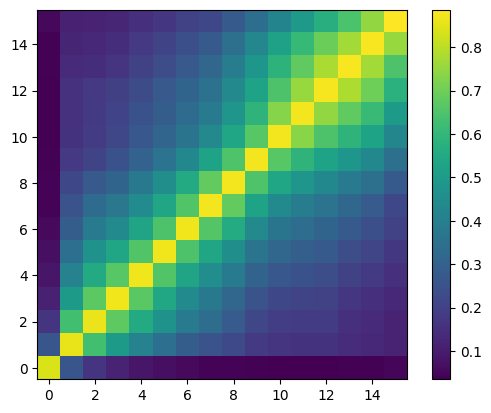

In [43]:
# first do cossine sim between layers
data = []
for i in range(16):
    for j in range(16):
        sim=F.cosine_similarity(hs_cho[i], hs_rej[j], dim=-1).mean().item()
        # print(i,j, F.cosine/_similarity(hs_cho[i], hs_rej[j], dim=-1).mean().item())
        data.append(dict(i=i, j=j, sim=sim))
r = pd.DataFrame(data).pivot(index='i',columns='j')
plt.imshow(r, origin='lower')
plt.colorbar()

In [23]:
hs = hs_cho[-1]-(hs_cho-hs_cho[0])
hs.shape
hs.norm(dim=-1).mean(1)

tensor([20.3750, 20.3750, 18.2500, 18.2500, 18.1250, 18.0000, 17.8750, 17.7500,
        17.3750, 16.8750, 16.1250, 15.2500, 13.8125, 12.1875,  9.1250,  0.0000],
       device='cuda:0', dtype=torch.bfloat16)

In [24]:
hs = hs_cho[-1]-hs_cho
hs.shape
hs.norm(dim=-1).mean(1)

tensor([20.3750, 20.3750, 18.2500, 18.2500, 18.1250, 18.0000, 17.8750, 17.7500,
        17.3750, 16.8750, 16.1250, 15.2500, 13.8125, 12.1875,  9.1250,  0.0000],
       device='cuda:0', dtype=torch.bfloat16)

In [16]:
a = hs_cho.diff(0).cumsum(0)
a.norm(dim=-1).mean(1)

tensor([  0.9258,   2.7812,   7.3125,  12.5000,  17.8750,  23.2500,  28.7500,
         34.5000,  40.2500,  46.2500,  53.2500,  61.5000,  71.5000,  83.0000,
         97.0000, 112.5000], device='cuda:0', dtype=torch.bfloat16)

In [17]:
a.shape

torch.Size([16, 196, 2048])

In [18]:
hs_cho.norm(dim=-1).mean(1)

tensor([ 0.9258,  2.3281,  5.0000,  5.7500,  6.1875,  6.4062,  6.7188,  7.0938,
         7.2812,  7.9688,  9.6250, 10.8125, 12.6250, 14.6875, 17.1250, 20.3750],
       device='cuda:0', dtype=torch.bfloat16)

## Suppression stats

In [19]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm

In [20]:
# Get MLP output weights from final layer
W_out = model.model.layers[-1].mlp.down_proj.weight.T # Adjust path as needed for Llama
# Get unembedding matrix 
W_U = model.lm_head.weight

# Calculate logit effects
logit_effects = W_out @ W_U.T

logit_effects = logit_effects.float().cpu().detach().numpy()
logit_effects.shape

(8192, 128256)

In [21]:
1/0

ZeroDivisionError: division by zero

In [ ]:

# Analyze distribution per neuron
import scipy.stats
kurtosis = scipy.stats.kurtosis(logit_effects, axis=1)
# kurtosis = torch.kurtosis(logit_effects, dim=1)
skew = scipy.stats.skew(logit_effects.float().cpu().detach().numpy(), axis=1)
# skew = torch.skew(logit_effects, dim=1)


In [ ]:

some_threshold = 1
# Identify suppression neurons (high kurtosis, negative skew)
suppression_mask = (kurtosis > some_threshold) & (skew < 0)
